

# Упражнение 5.2


Пример кода в упражнении 5.1 показывает, как использовать автокорреляцию для оценки основной частоты периодического сигнала. Инкапсулируем этот код в функцию с именем estimate_fundamental и используем её для отслеживания высоты тона записанного звука.

Чтобы увидеть, насколько хорошо это работает, попробуем наложить свои оценки высоты тона на спектрограмму записи.

In [31]:
import os
import thinkdsp
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('28042__bcjordan__voicedownbew.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav

In [21]:
from thinkdsp import read_wave
from thinkdsp import decorate
wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

Воспользуемся примером из упражнения 1. Получим спектрограмму:

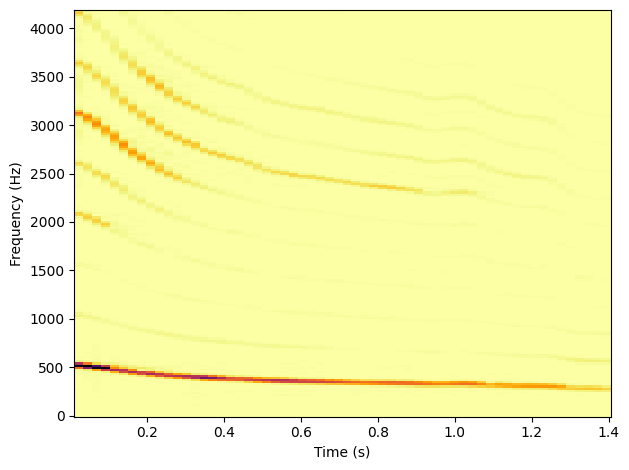

In [6]:
wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)',
         ylabel='Frequency (Hz)')

In [27]:
def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

def serial_corr(wave, lag=1):
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

In [28]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

А вот петля, которая отслеживает высоту звука по сэмплу.

ts является серединой каждого сегмента.

In [29]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)


Вот кривая отслеживания высоты тона, наложенная на спектрограмму:

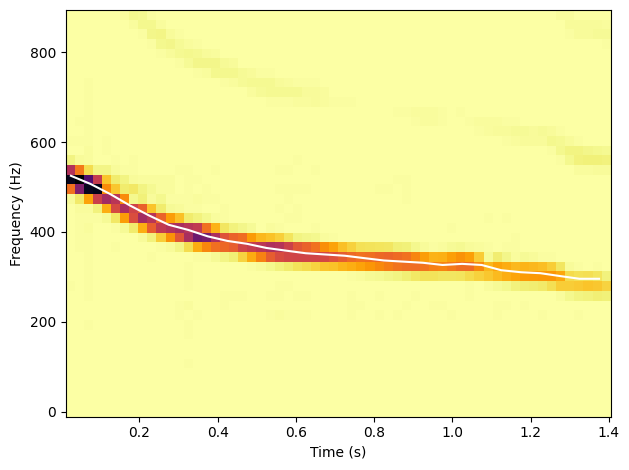

In [32]:
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)',
                     ylabel='Frequency (Hz)')

# Упражнение 5.3



Для начала импортируем необходимые библиотеки:

In [33]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

Используя данные из предыдущей главы, вычислим автокорреляцию цен на биткойны. Определим, имеются ли признаки периодического поведения.

Получим данные:

In [34]:
if not os.path.exists('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv

--2024-06-13 16:49:37--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv [following]
--2024-06-13 16:49:38--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143622 (140K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 140.26K  --.-KB/s    in 0.

Создадим pandas dataframe на основе данных:

In [35]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv',
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

Распечатаем график цены биткоина:

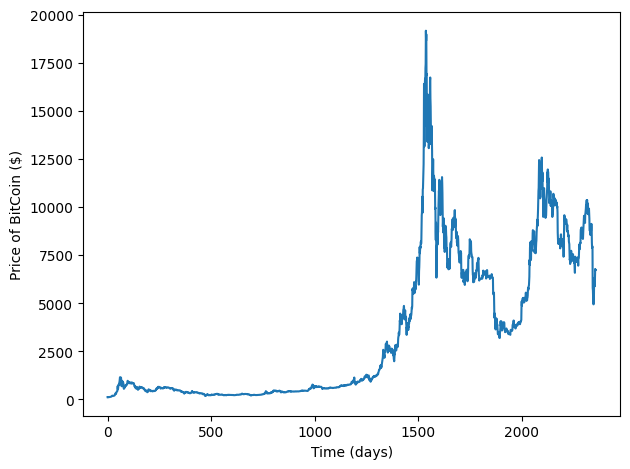

In [36]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

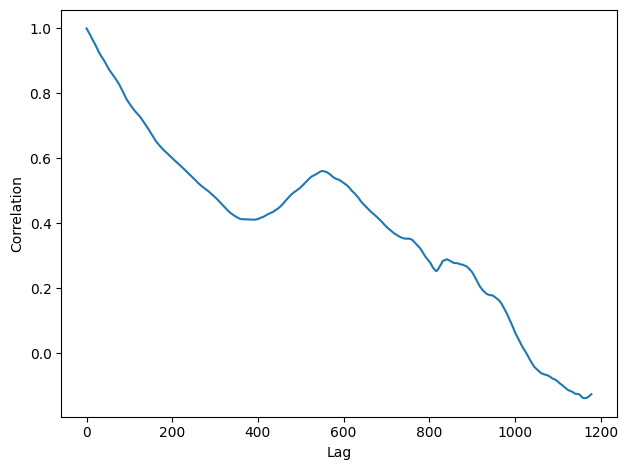

In [37]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

ACF медленно падает по мере увеличения запаздывания, что указывает на некий шум.

Мы можем сравнить реализацию autocorr с np.correlate, которая использует определение корреляции, используемое при обработке сигналов. Он не устраняет смещение, не нормализует и не стандартизирует волну.

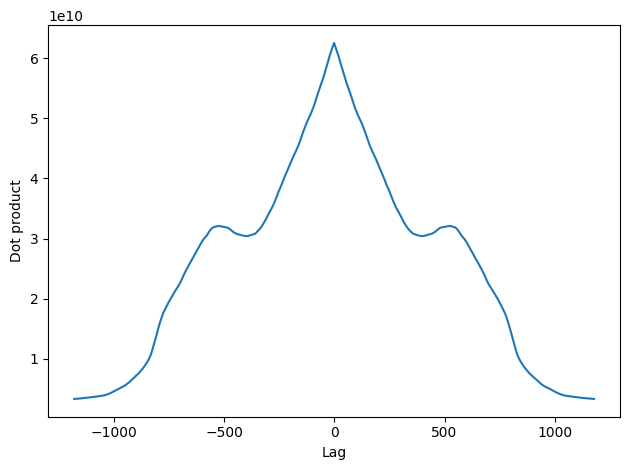

In [38]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate(xlabel='Lag',
         ylabel='Dot product')

Вторая половина результата соответствует положительным лагам:

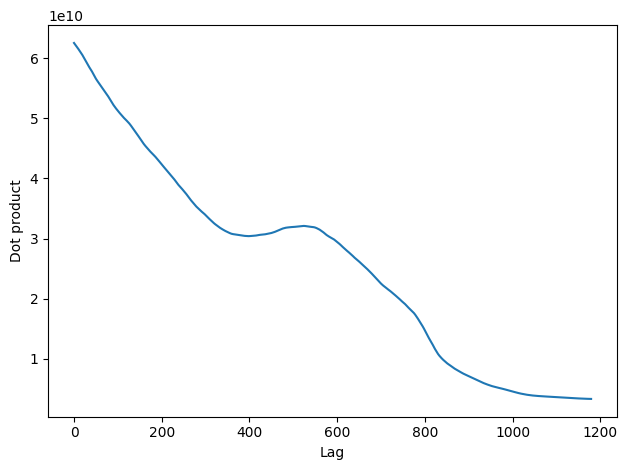

In [39]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Мы можем стандартизировать результаты постфактум, разделив их на длины:

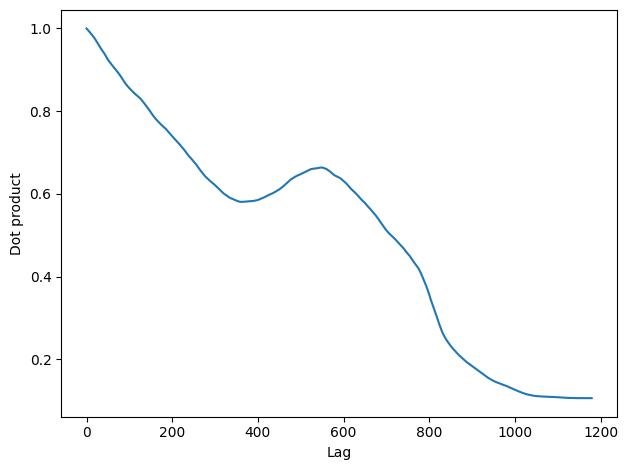

In [40]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Теперь мы можем сравнить их.

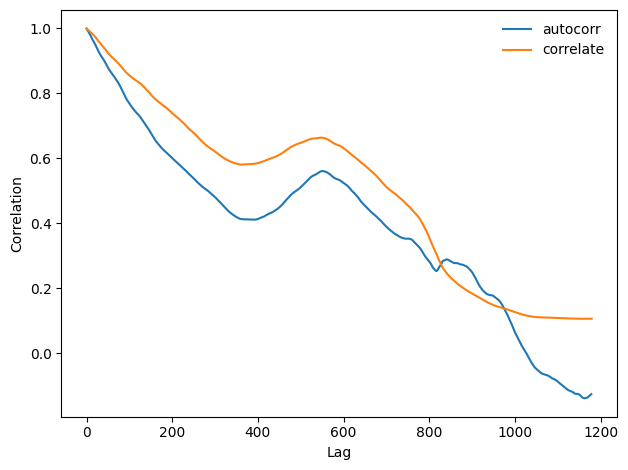

In [41]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate(xlabel='Lag', ylabel='Correlation')

Даже после стандартизации результаты выглядят существенно иначе.

Для этого набора данных более подходящим является статистическое определение АКФ.